# Harmonizing OsmFISH dataset (Linarsson Lab) and Zeisel's Cortex dataset

# Table of Contents
0. [Creating and training the model](#Creating and training the model)
1. [Imputation](#Imputation)
2. [Getting a common meaningful representation](#Getting a common meaningful representation)
3. [Classifying smFISH cells in different cell types](#Classifying smFISH cells in different cell types)
3. [Imputation of non-observed genes for OsmFISH](#Imputation of non-observed genes for OsmFISH)

## Imputation
We train our model and the baseline without observing some smFISH genes (sox10 and Gad2 in this exemple). We then try to reconstruct the unobserved values for each cell, an compare them with the real ones. 
For the baseline we use a k-NN approach, and for our model we directly output the expected counts.
We also compute, for each of those unobserved genes, the absolute and relative errors.
## Getting a common meaningful representation
Here, we'd like two things. First, the two datasets should mix pretty well (if the common representation captures biologically relevant information). This is measured by the Entropy of Batch Mixing (maximum possible value: 0.68, minimum possible value: 0.00, value for our method: 0.50, value for baseline: 0.10).
We also plot the latent represnetation of the cells according to their cell types, hoping that cells from different datasets but same cell types lie close to each other in our latent space.
To check that our representation is meaningful, we plot the expression of marker genes for sub-cell types for scRNA-seq data. That allows us to see that our representation conserves data structure at the sub cell type level.
## Classifying smFISH cells in different cell types
Here, we use a k-NN classifier for the baseline, and a SVC classifier on the expected frequencies of the model for our method.
## Imputation of non-observed genes for OsmFISH
We start by imputing marker genes for different cell types and show that the expected frequencies are correlated with the expression of other marker genes for the same cell types, to ensure consistency of our model.
We then impute a gene supposed to be spatially differentially expressed, and show that the expected counts imputed by our model for this gene are also spatially differentially expressed (last figure of the notebook).


In [1]:
import os
os.chdir("/home/jules/PycharmProjects/scVI/")
os.getcwd()

'/home/jules/PycharmProjects/scVI'

In [2]:
import json
with open('docs/notebooks/scRNA_and_smFISH.config.json') as f:
    config = json.load(f)
print(config)

n_epochs_all = config['n_epochs'] if 'n_epochs' in config else None
save_path = config['save_path'] if 'save_path' in config else 'data/'
n_samples_tsne = config['n_samples_tsne'] if 'n_samples_tsne' in config else None
n_samples_posterior_density = config['n_samples_posterior_density'] if 'n_samples_posterior_density' in config else None
train_size = config['train_size'] if 'train_size' in config else None
M_sampling = config['M_sampling'] if 'M_sampling' in config else None
M_permutation = config['M_permutation'] if 'M_permutation' in config else None
rate = config['rate'] if 'rate' in config else None

{'save_path': 'data/'}


In [3]:
import numpy as np
from sklearn.decomposition import PCA
from scvi.dataset import CortexDataset, SmfishDataset, GeneExpressionDataset
from scvi.inference import TrainerFish, UnsupervisedTrainer
from scvi.models import VAEF, VAE
from scvi.inference.posterior import plot_imputation, proximity_imputation, entropy_batch_mixing
from scvi.inference.annotation import compute_accuracy_nn
from MNNs import MNN
from scipy.stats import spearmanr
from sklearn.manifold import TSNE
import umap
import torch
import matplotlib.pyplot as plt
%matplotlib inline

/home/jules/miniconda3/envs/env3.7/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence
/home/jules/miniconda3/envs/env3.7/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# 1. Creating and training the model

bons genes: gfap,cpne5, kcnip2, lamp5 plp1, rorb serpinf1, sox10 syt6

In [4]:
genes_to_discard = ['sox10']
gene_dataset_fish = SmfishDataset(save_path=save_path)
gene_names = gene_dataset_fish.gene_names
l = []
for n_gene in range(len(gene_names)):
    for gene in genes_to_discard:
        if gene_names[n_gene].lower() == gene.lower():
            l.append(n_gene)
genes_to_discard = l
indexes_to_keep = np.arange(len(gene_names))
indexes_to_keep = np.delete(indexes_to_keep, genes_to_discard)
# The "genes_to_discard" argument is given here so that the order of the genes in CortexDataset matches
# the order in SmfishDataset

File data/osmFISH_SScortex_mouse_all_cell.loom already downloaded
Preprocessing smFISH dataset
Finished preprocessing smFISH dataset


 We run with 50 additional genes for the scRNA-seq dataset

In [5]:
gene_dataset_seq = CortexDataset(save_path=save_path,
                                 genes_fish=gene_dataset_fish.gene_names, 
                                 genes_to_keep=["mog", "sst", "gja1", "ctss", "ndnf"], additional_genes=50)

File data/expression.bin already downloaded
Preprocessing Cortex data
Finished preprocessing Cortex data


In [6]:
# also remove bogus cells when we will filter more genes (PCA, MNNs and scVI)
to_keep = np.where(np.sum(gene_dataset_fish.X[:, indexes_to_keep], axis=1) > 0)[0]
gene_dataset_fish.update_cells(to_keep)
gene_dataset_fish.x_coord = gene_dataset_fish.x_coord[to_keep]
gene_dataset_fish.y_coord = gene_dataset_fish.y_coord[to_keep]
to_keep = np.where(np.sum(gene_dataset_seq.X[:, indexes_to_keep], axis=1) > 0)[0]
gene_dataset_seq.update_cells(to_keep)

Downsampling from 4462 to 4462 cells
Downsampling from 2485 to 2485 cells


In [7]:
n_epochs = 100 if n_epochs_all is None else n_epochs_all
vae = VAEF(gene_dataset_seq.nb_genes, indexes_to_keep, n_layers_decoder=1, n_latent=8,
           n_layers_shared=1, n_hidden=256, reconstruction_loss='nb',
           n_batch=2, model_library=False)
trainer = TrainerFish(vae, gene_dataset_seq, gene_dataset_fish, 
                      verbose=False, weight_decay=0.30)
trainer.train(n_epochs=n_epochs, lr=0.001)

training: 100%|██████████| 100/100 [01:31<00:00,  1.10it/s]


In [8]:
dic = trainer.get_all_latent_and_expected_frequencies(save_imputed=True, save_latent=True, 
                                                file_name_imputation="seq_expected_frequencies", 
                                                file_name_latent="latent_seq", mode="scRNA")
latent_seq, expected_frequencies_seq = dic["latent"], dic["expected_frequencies"]

dic = trainer.get_all_latent_and_expected_frequencies(save_imputed=True, 
                                                      file_name_imputation='fish_expected_frequencies', 
                                                      save_latent=True, 
                                                      file_name_latent='latent_fish')
latent_fish, expected_frequencies_fish = dic["latent"], dic["expected_frequencies"]

## Creating the PCA and MNN baselines

In [9]:
# In these baselines, we need to work only with geneset intersection
concatenated_matrix = np.concatenate((gene_dataset_fish.X[:, vae.indexes_to_keep], gene_dataset_seq.X[:, vae.indexes_to_keep]))

#we normalize for PCA
normalized_matrix = concatenated_matrix / np.sum(concatenated_matrix, axis=1)[:, np.newaxis]
normalized_matrix = np.log(1 + 1e4 * normalized_matrix)
latent_pca = PCA(n_components=8).fit_transform(normalized_matrix)
pca_latent_fish = latent_pca[:gene_dataset_fish.X.shape[0], :]
pca_latent_seq = latent_pca[gene_dataset_fish.X.shape[0]:, :]

# we correct with MNNs
MNN_corrected_matrix = MNN().fit_transform(concatenated_matrix, np.concatenate(
    (np.zeros(gene_dataset_fish.X.shape[0]), np.ones(gene_dataset_seq.X.shape[0]))), [0, 1])
latent_mnn = PCA(n_components=8).fit_transform(MNN_corrected_matrix)
mnn_latent_fish = latent_mnn[:gene_dataset_fish.X.shape[0], :]
mnn_latent_seq = latent_mnn[gene_dataset_fish.X.shape[0]:, :]

# 2. Creating and training the original scVI model as a baseline

The scVI model is also designed to do batch effect corrections on datasets that contain multiple batches. We are going to use it as a baseline that we compare to this new model that has been created by modifying the scVI model to address specifically this harmonization problem.

In [10]:
def run_scvi():
    gene_dataset_fish = SmfishDataset(save_path=save_path)
    gene_names = gene_dataset_fish.gene_names
    to_keep = np.where(np.sum(gene_dataset_fish.X[:, indexes_to_keep], axis=1) > 0)[0]
    gene_dataset_fish.update_cells(to_keep)


    gene_dataset_seq_scvi = CortexDataset(save_path=save_path,
                                     genes_fish=gene_dataset_fish.gene_names,
                                     genes_to_keep=[], additional_genes=0)

    # Uniformying the gene names so that we can concatenate datasets on gene names
    gene_dataset_seq_scvi.gene_names = np.array([gene.lower() for gene in gene_dataset_seq_scvi.gene_names])
    gene_dataset_fish.gene_names = np.array([gene.lower() for gene in gene_dataset_fish.gene_names])
    
    gene_dataset = GeneExpressionDataset.concat_datasets(gene_dataset_fish, gene_dataset_seq_scvi)
    gene_dataset.filter_genes(gene_dataset_fish.gene_names[indexes_to_keep])
    vae = VAE(gene_dataset.nb_genes, n_batch=2,
          n_labels=gene_dataset.n_labels, dispersion="gene-batch", reconstruction_loss="nb")

    trainer = UnsupervisedTrainer(vae, gene_dataset, train_size=0.9, use_cuda=True)
    trainer.train(n_epochs=100, lr=0.001)
    dic = trainer.get_all_latent_and_imputed_values()
    latent_scvi = dic["latent"]
    latent_scvi_fish = latent_scvi[:gene_dataset_fish.X.shape[0]]
    latent_scvi_seq = latent_scvi[gene_dataset_fish.X.shape[0]:]
    return latent_scvi_fish, latent_scvi_seq
latent_scvi_fish, latent_scvi_seq = run_scvi()

File data/osmFISH_SScortex_mouse_all_cell.loom already downloaded
Preprocessing smFISH dataset
Finished preprocessing smFISH dataset
Downsampling from 4462 to 4462 cells
File data/expression.bin already downloaded
Preprocessing Cortex data
Finished preprocessing Cortex data
Keeping 33 genes
Downsampling from 33 to 32 genes
Downsampling from 6947 to 6947 cells
training: 100%|██████████| 100/100 [00:42<00:00,  2.35it/s]


## KNN purity

In [64]:
# Creating the individual analysis
def individual_analysis():
    gene_dataset_fish.x_coord = None
    gene_dataset_fish.y_coord = None
    vae = VAE(gene_dataset_fish.nb_genes, dispersion="gene", reconstruction_loss="nb")

    trainer = UnsupervisedTrainer(vae, gene_dataset_fish, train_size=0.9, use_cuda=True)
    trainer.train(n_epochs=100, lr=0.001)
    dic = trainer.get_all_latent_and_imputed_values()
    latent = dic["latent"]
    return latent
latent_individual_fish = individual_analysis()

training: 100%|██████████| 100/100 [00:26<00:00,  3.83it/s]


In [60]:
latent_individual_fish = PCA(n_components=8).fit_transform(np.log(1 + 1e4*gene_dataset_fish.X))

In [33]:
def get_neighbours(latent, n_neighbors):
    nbrs = NearestNeighbors(n_neighbors=n_neighbors + 1).fit(latent)
    indices = nbrs.kneighbors(latent, return_distance=False)[:, 1:]
    return indices

from sklearn.metrics import jaccard_similarity_score
from sklearn.neighbors import NearestNeighbors

In [65]:
individual_neighbours = []
in_mixed_neighbours = {'model': [], 'pca': [], 'mnn': [], 'scvi': []}

for k in range(20):
    individual_neighbours.append(get_neighbours(latent_individual_fish, 5*(k + 1)))
    in_mixed_neighbours['model'].append(get_neighbours(latent_fish, 5*(k + 1)))
    in_mixed_neighbours['pca'].append(get_neighbours(pca_latent_fish, 5*(k + 1)))
    in_mixed_neighbours['mnn'].append(get_neighbours(mnn_latent_fish, 5*(k + 1)))
    in_mixed_neighbours['scvi'].append(get_neighbours(latent_scvi_fish, 5*(k + 1)))

In [55]:
def get_jaccard_metrics(indiv_neighbours, mixed_neighbours):
    jaccard = []
    for i in range(indiv_neighbours.shape[0]):
        jaccard.append(jaccard_similarity_score(indiv_neighbours[i], mixed_neighbours[i]))
    return np.mean(jaccard)

In [66]:
purity_model = [get_jaccard_metrics(np.asarray(individual_neighbours[k]), 
                                         np.asarray(in_mixed_neighbours["model"][k])) for k in range(20)]
purity_pca = [get_jaccard_metrics(np.asarray(individual_neighbours[k]), 
                                       np.asarray(in_mixed_neighbours["pca"][k])) for k in range(20)]
purity_mnn = [get_jaccard_metrics(np.asarray(individual_neighbours[k]), 
                                       np.asarray(in_mixed_neighbours["mnn"][k])) for k in range(20)]
purity_scvi = [get_jaccard_metrics(np.asarray(individual_neighbours[k]), 
                                        np.asarray(in_mixed_neighbours["scvi"][k])) for k in range(20)]

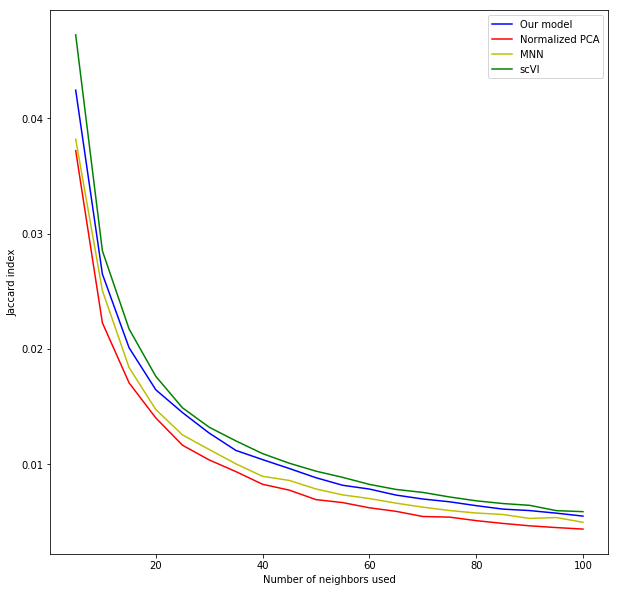

In [69]:
plt.figure(figsize=(10, 10))
x = np.linspace(5, 100, num=20)
plt.plot(x, purity_model, color='b', label='Our model')
plt.plot(x, purity_pca, color='r', label='Normalized PCA')
plt.plot(x, purity_mnn, color='y', label='MNN')
plt.plot(x, purity_scvi, color='g', label='scVI')
plt.xlabel("Number of neighbors used")
plt.ylabel("Jaccard index")
plt.legend()
#plt.show()
plt.savefig('/home/jules/fish/knn_purity_plot.pdf')

## Latent embedding plots

In [70]:
def get_common_umap(latent_seq, latent_fish):
    full_latent = np.concatenate((latent_seq, latent_fish))
    if full_latent.shape[1] != 2:
        latent =  TSNE().fit_transform(full_latent)
    return latent[:latent_seq.shape[0], :], latent[latent_seq.shape[0]:, :]

t_sne_seq, t_sne_fish = get_common_umap(latent_seq, latent_fish)
t_sne_PCA_seq, t_sne_PCA_fish = get_common_umap(pca_latent_seq, pca_latent_fish)
t_sne_mnn_seq, t_sne_mnn_fish = get_common_umap(mnn_latent_seq, mnn_latent_fish)
t_sne_scvi_seq, t_sne_scvi_fish = get_common_umap(latent_scvi_seq, latent_scvi_fish)

In [71]:
batch_indices = np.concatenate(
    (np.zeros(gene_dataset_fish.X.shape[0]), np.ones(gene_dataset_seq.X.shape[0])))

In [89]:
latent = np.concatenate((t_sne_scvi_fish, t_sne_scvi_seq), axis=0)
labels = np.concatenate((gene_dataset_fish.labels, gene_dataset_seq.labels))
cell_types = gene_dataset_seq.cell_types[:(len(gene_dataset_seq.cell_types)-1)]
cell_types[len(cell_types)-1] = 'pyramidal'
for label in range(len(labels)):
    if labels[label] == 6:
        labels[label] = 5

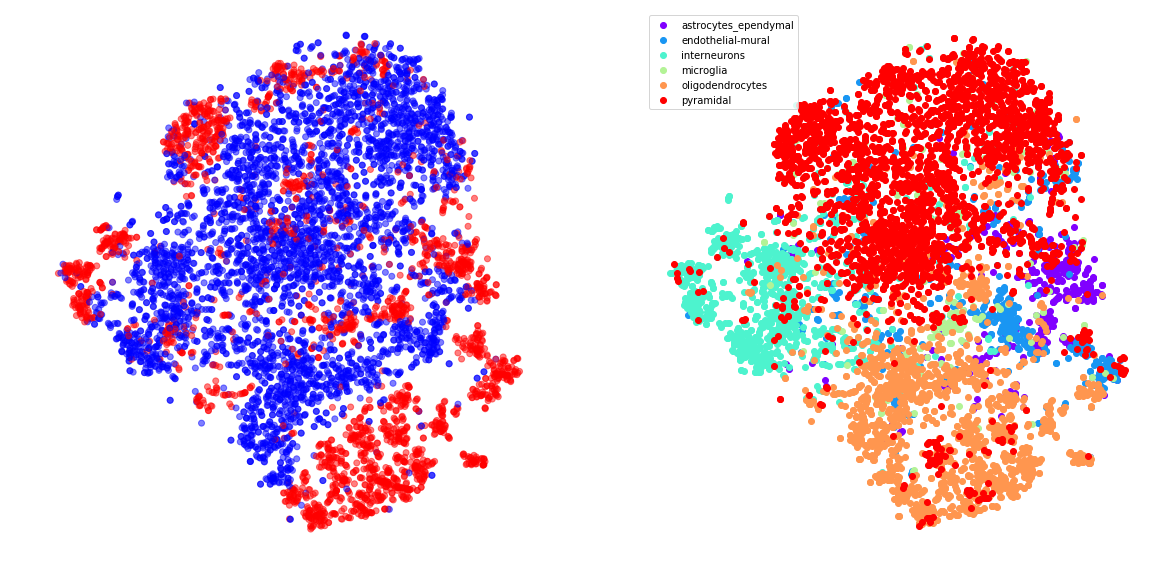

In [91]:
import matplotlib.cm as cm
flip_idx = np.random.permutation(np.arange(latent.shape[0]))
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.scatter(latent[flip_idx, 0], latent[flip_idx, 1], c=batch_indices[flip_idx], cmap=plt.get_cmap('bwr'), alpha=0.5)
plt.subplot(1, 2, 2)
plt.axis("off")
colors = cm.rainbow(np.linspace(0, 1, 6))
for i, c in zip(np.unique(labels), colors):
    plt.scatter(latent[labels.ravel() == i, 0], 
                latent[labels.ravel() == i, 1], color=c, label=cell_types[i])
plt.legend(loc='upper left')
plt.savefig('/home/jules/fish/latent_embedding_scvi.pdf')
#plt.show()


# 3. Imputation

In [9]:
def get_index(gene_names, gene):
    idx = 0
    for gene_cortex in range(len(gene_names)):
        if gene_names[gene_cortex].lower() == gene.lower():
            idx = gene_cortex
            print("Found idx " + str(idx) + " for gene " + gene + "!")
    return idx

idx_serpinf1 = get_index(gene_dataset_seq.gene_names, "serpinf1")
idx_sox = get_index(gene_dataset_seq.gene_names, "sox10")
idx_syt6 = get_index(gene_dataset_seq.gene_names, "syt6")

Found idx 15 for gene serpinf1!
Found idx 17 for gene sox10!
Found idx 11 for gene syt6!


In [10]:
print(gene_dataset_seq.X.shape)
print(gene_dataset_fish.X.shape)
print(latent_scvi_fish.shape)
print(latent_scvi_seq.shape)

(2485, 82)
(4462, 33)


NameError: name 'latent_scvi_fish' is not defined

## Imputing missing gene: our method vs baselines

In [239]:
def imputation_metrics(original, imputed):
    absolute_error = np.abs(original - imputed)
    relative_error = absolute_error / np.maximum(np.abs(original), np.ones_like(original))
    spearman = spearmanr(original, imputed)[0]
    return {"mean_absolute_error": np.mean(absolute_error), "median_absolute_error": np.median(absolute_error), 
            "mean_relative_error": np.mean(relative_error), "median_relative_error": np.median(relative_error), 
            "spearman": spearman}

GAD2

In [19]:
gene_interest = idx_sox
#gene_interest = idx_sox
#plot_imputation(np.log(1 + predicted_PCA), np.log(1 + gene_dataset_fish.X[:, idx_gad]))

In [20]:
imputed = np.copy(expected_frequencies_fish[:, gene_interest])
imputed /= np.sum(expected_frequencies_fish[:, vae.indexes_to_keep], axis=1).ravel()
print(imputed.shape)
imputed *= np.sum(gene_dataset_fish.X[:, vae.indexes_to_keep], axis=1)


#pca_imputed = proximity_imputation(pca_latent_seq, gene_dataset_seq.X[:, gene_interest], pca_latent_fish, k=5)


#mnn_imputed = proximity_imputation(mnn_latent_seq, gene_dataset_seq.X[:, gene_interest], mnn_latent_fish, k=5)


#scvi_imputed = proximity_imputation(latent_scvi_seq, gene_dataset_seq.X[:, gene_interest], latent_scvi_fish, k=5)


(4462,)


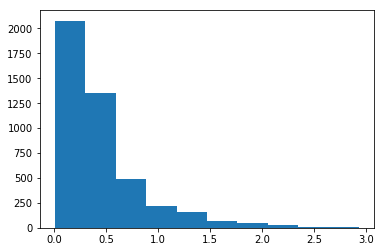

In [242]:
plt.hist(np.log(1 + imputed).ravel())
plt.show()

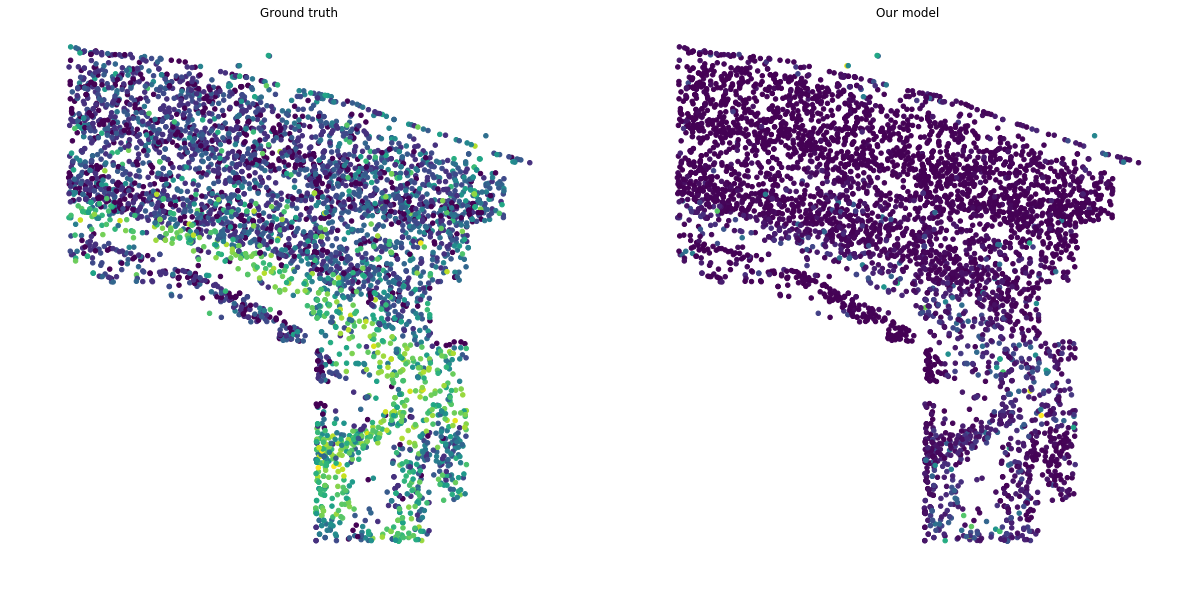

In [22]:
x = gene_dataset_fish.x_coord
y = gene_dataset_fish.y_coord
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.scatter(x.ravel(), y.ravel(), c=np.log(1 + gene_dataset_fish.X[:, gene_interest]).squeeze(), s=20)
plt.title("Ground truth")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.scatter(x.ravel(), y.ravel(), c=np.log(1 + expected_frequencies_fish[:, gene_interest]).squeeze(), s=20)
plt.title("Our model")
plt.axis('off')
plt.show()
#plt.savefig("/home/jules/fish/truth_vs_model_sox10.pdf")

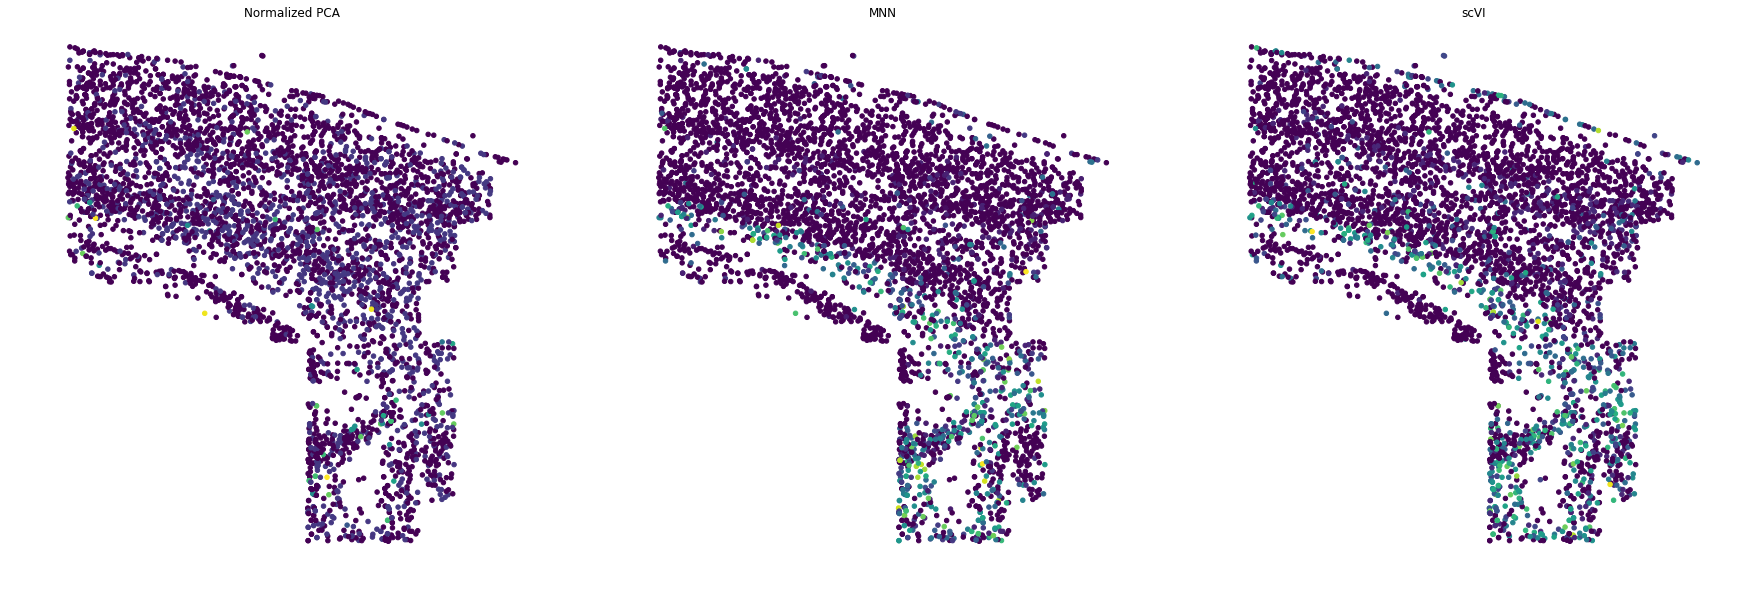

In [244]:
plt.figure(figsize=(30, 10))
plt.subplot(1, 3, 1)
plt.scatter(x.ravel(), y.ravel(), c=np.log(1 + pca_imputed).squeeze(), s=20)
plt.title("Normalized PCA")
plt.axis('off')
plt.subplot(1, 3, 2)
plt.scatter(x.ravel(), y.ravel(), c=np.log(1 + mnn_imputed).squeeze(), s=20)
plt.title("MNN")
plt.axis('off')
plt.subplot(1, 3, 3)
plt.scatter(x.ravel(), y.ravel(), c=np.log(1 + scvi_imputed).squeeze(), s=20)
plt.title("scVI")
plt.axis('off')
plt.savefig("/home/jules/fish/baselines_sox10.pdf")
#plt.show()

In [89]:
imputed = np.copy(expected_frequencies_fish[:, gene_interest])
imputed /= np.sum(expected_frequencies_fish[:, vae.indexes_to_keep], axis=1).ravel()
imputed *= np.sum(gene_dataset_fish.X[:, vae.indexes_to_keep], axis=1)
model_impute = imputation_metrics(gene_dataset_fish.X[:, gene_interest], imputed)

predicted_pca = proximity_imputation(pca_latent_seq, gene_dataset_seq.X[:, gene_interest], pca_latent_fish, k=5)
pca_impute = imputation_metrics(gene_dataset_fish.X[:, gene_interest], predicted_pca)

predicted_mnn = proximity_imputation(mnn_latent_seq, gene_dataset_seq.X[:, gene_interest], mnn_latent_fish, k=5)
mnn_impute = imputation_metrics(gene_dataset_fish.X[:, gene_interest], predicted_mnn)

predicted_scvi = proximity_imputation(latent_scvi_seq, gene_dataset_seq.X[:, gene_interest], latent_scvi_fish, k=5)
scvi_impute = imputation_metrics(gene_dataset_fish.X[:, gene_interest], predicted_scvi)

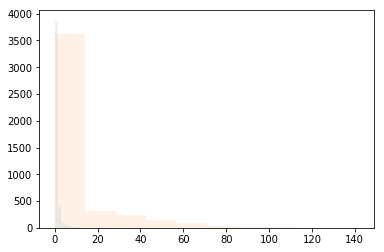

In [90]:
plt.hist(imputed, alpha=0.1)
plt.hist(gene_dataset_fish.X[:, gene_interest], alpha=0.1)
plt.show()

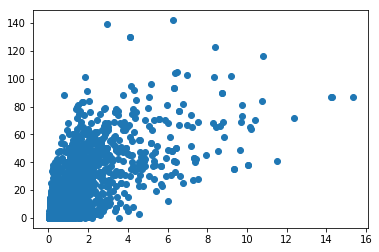

In [91]:
plt.scatter(imputed, gene_dataset_fish.X[:, gene_interest])

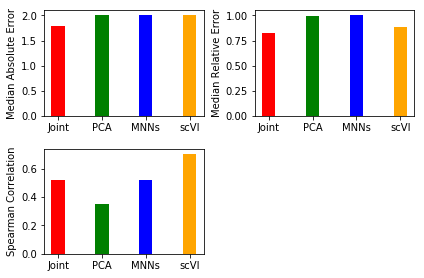

In [92]:
res_list = [model_impute, pca_impute, mnn_impute, scvi_impute]
mae = [x["median_absolute_error"] for x in res_list]
mre = [x["median_relative_error"] for x in res_list]
spc = [x["spearman"] for x in res_list]

plt.subplot(221)
ind = np.arange(4)
joint_plot, pca_plot, mnn_plot, scvi_plot = plt.bar(ind, mae, width=0.3)
plt.xticks(ind, ['Joint', 'PCA', 'MNNs', 'scVI'])
joint_plot.set_facecolor('r')
pca_plot.set_facecolor('g')
mnn_plot.set_facecolor('b')
scvi_plot.set_facecolor('orange')
plt.ylabel("Median Absolute Error")

plt.subplot(222)
ind = np.arange(4)
joint_plot, pca_plot, mnn_plot, scvi_plot = plt.bar(ind, mre, width=0.3)
plt.xticks(ind, ['Joint', 'PCA', 'MNNs', 'scVI'])
joint_plot.set_facecolor('r')
pca_plot.set_facecolor('g')
mnn_plot.set_facecolor('b')
scvi_plot.set_facecolor('orange')
plt.xticks(ind, ['Joint', 'PCA', 'MNNs', 'scVI'])
plt.ylabel("Median Relative Error")


plt.subplot(223)
ind = np.arange(4)
joint_plot, pca_plot, mnn_plot, scvi_plot = plt.bar(ind, spc, width=0.3)
plt.xticks(ind, ['Joint', 'PCA', 'MNNs', 'scVI'])
joint_plot.set_facecolor('r')
pca_plot.set_facecolor('g')
mnn_plot.set_facecolor('b')
scvi_plot.set_facecolor('orange')
plt.xticks(ind, ['Joint', 'PCA', 'MNNs', 'scVI'])
plt.ylabel("Spearman Correlation")

plt.tight_layout()
plt.show()

In [93]:
labels = np.concatenate((gene_dataset_seq.labels.ravel(), gene_dataset_fish.labels.ravel()), axis=0)
batch_indices = np.concatenate(((np.zeros(gene_dataset_seq.X.shape[0])), 
                                np.ones(gene_dataset_fish.X.shape[0])), axis=0)

## Batch entropy: How well do the datasets mix in the latent space?

Text(0,0.5,'Batch Entropy Mixing')

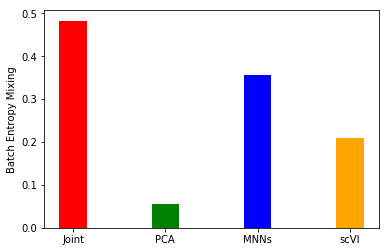

In [94]:
model_mix = entropy_batch_mixing(np.concatenate((latent_seq, latent_fish)),
                           batches=batch_indices)
pca_mix = entropy_batch_mixing(np.concatenate((pca_latent_seq, pca_latent_fish)),
                               batches=batch_indices)
mnn_mix = entropy_batch_mixing(np.concatenate((mnn_latent_seq, mnn_latent_fish)),
                               batches=batch_indices)
scvi_mix = entropy_batch_mixing(np.concatenate((latent_scvi_seq, latent_scvi_fish)),
                               batches=batch_indices)

be = [model_mix, pca_mix, mnn_mix, scvi_mix]
ind = np.arange(4)
joint_plot, pca_plot, mnn_plot, scvi_plot = plt.bar(ind, be, width=0.3)
plt.xticks(ind, ['Joint', 'PCA', 'MNNs', 'scVI'])
joint_plot.set_facecolor('r')
pca_plot.set_facecolor('g')
mnn_plot.set_facecolor('b')
scvi_plot.set_facecolor('orange')
plt.ylabel("Batch Entropy Mixing")

# 5. Classifying cells in different cell types

In [95]:
# No distinction between pyramidal CA1 and pyramidal SS in the OsmFISH dataset
labels_seq = np.copy(gene_dataset_seq.labels.ravel())
for label in range(len(labels_seq)):
    if labels_seq[label] == 6:
        labels_seq[label] = 5

(_, accuracy), inferred_labels = compute_accuracy_nn(latent_seq, labels_seq, 
                                                     latent_fish, gene_dataset_fish.labels.ravel())
(_, PCA_accuracy), PCA_inferred_labels = compute_accuracy_nn(pca_latent_seq, labels_seq,
                                                    pca_latent_fish, gene_dataset_fish.labels.ravel())
(_, mnn_accuracy), mnn_inferred_labels = compute_accuracy_nn(mnn_latent_seq, labels_seq,
                                                    mnn_latent_fish, gene_dataset_fish.labels.ravel())
(_, scvi_accuracy), mnn_inferred_labels = compute_accuracy_nn(latent_scvi_seq, labels_seq,
                                                    latent_scvi_fish, gene_dataset_fish.labels.ravel())

We used a KNN classifier based on our latent space and the baselines' latent space to compute these accuracies                     

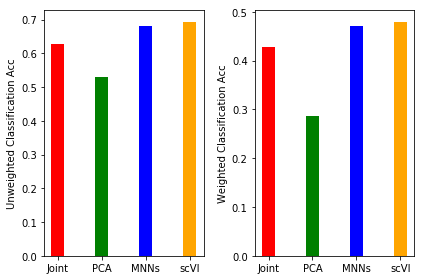

In [96]:
res_list = [accuracy, PCA_accuracy, mnn_accuracy, scvi_accuracy]
unw = [x.unweighted for x in res_list]
we = [x.weighted for x in res_list]

plt.subplot(121)
ind = np.arange(4)
joint_plot, pca_plot, mnn_plot, scvi_plot = plt.bar(ind, unw, width=0.3)
plt.xticks(ind, ['Joint', 'PCA', 'MNNs', 'scVI'])
joint_plot.set_facecolor('r')
pca_plot.set_facecolor('g')
mnn_plot.set_facecolor('b')
scvi_plot.set_facecolor('orange')
plt.ylabel("Unweighted Classification Acc")

plt.subplot(122)
ind = np.arange(4)
joint_plot, pca_plot, mnn_plot, scvi_plot = plt.bar(ind, we, width=0.3)
plt.xticks(ind, ['Joint', 'PCA', 'MNNs', 'scVI'])
joint_plot.set_facecolor('r')
pca_plot.set_facecolor('g')
mnn_plot.set_facecolor('b')
scvi_plot.set_facecolor('orange')
plt.xticks(ind, ['Joint', 'PCA', 'MNNs', 'scVI'])
plt.ylabel("Weighted Classification Acc")

plt.tight_layout()
plt.show()

# 4. Getting a common meaningful representation

In [28]:
def get_common_umap(latent_seq, latent_fish):
    full_latent = np.concatenate((latent_seq, latent_fish))
    if full_latent.shape[1] != 2:
        latent =  umap.UMAP().fit_transform(full_latent)
    return latent[:latent_seq.shape[0], :], latent[latent_seq.shape[0]:, :]

t_sne_seq, t_sne_fish = get_common_umap(latent_seq, latent_fish)
t_sne_PCA_seq, t_sne_PCA_fish = get_common_umap(pca_latent_seq, pca_latent_fish)
t_sne_mnn_seq, t_sne_mnn_fish = get_common_umap(mnn_latent_seq, mnn_latent_fish)
t_sne_scvi_seq, t_sne_scvi_fish = get_common_umap(latent_scvi_seq, latent_scvi_fish)

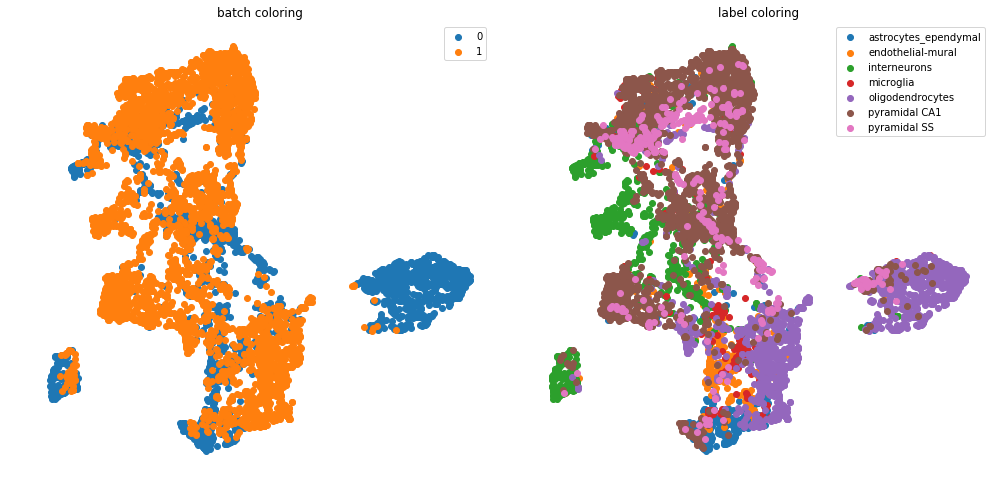

In [29]:
latent = np.concatenate((t_sne_seq, t_sne_fish), axis=0)
trainer.train_seq.show_t_sne(None, color_by = 'batches and labels', 
                             latent = latent, labels = labels, 
                             batch_indices = batch_indices, n_batch=2)

## Baselines: Embedding of the two datasets in the shared latent space

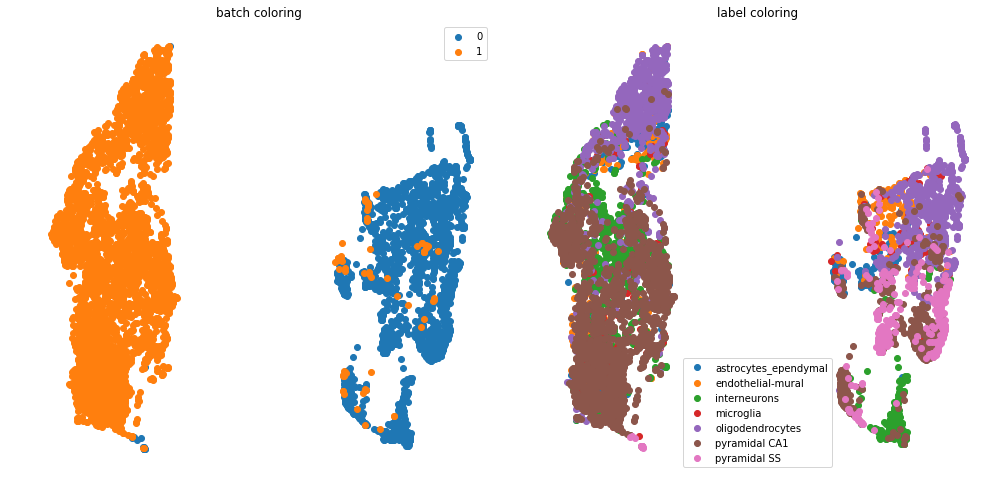

In [33]:
latent = np.concatenate((t_sne_PCA_seq, t_sne_PCA_fish), axis=0)
trainer.train_seq.show_t_sne(None, color_by='batches and labels', 
                             latent=latent, labels=labels, 
                             batch_indices=batch_indices, n_batch=2)

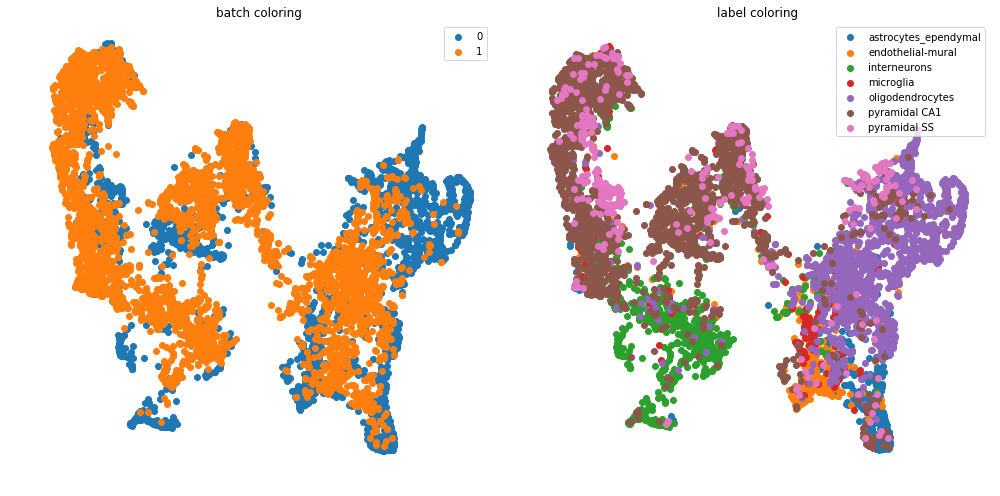

In [34]:
latent = np.concatenate((t_sne_mnn_seq, t_sne_mnn_fish), axis=0)
trainer.train_seq.show_t_sne(None, color_by='batches and labels', 
                             latent=latent, labels=labels, 
                             batch_indices=batch_indices, n_batch=2)

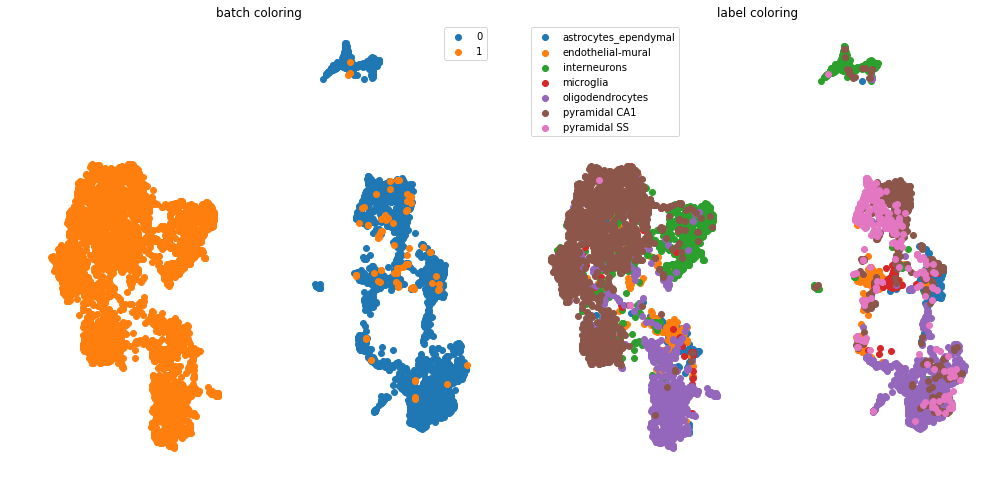

In [35]:
latent = np.concatenate((t_sne_scvi_seq, t_sne_scvi_fish), axis=0)
trainer.train_seq.show_t_sne(None, color_by='batches and labels', 
                             latent=latent, labels =labels, 
                             batch_indices=batch_indices, n_batch=2)

## Is the data structure conserved in the latent space?

We plot the values of expected frequencies of marker genes for sub-cell types for scRNA-seq data. If cells with high values for those genes are grouped together, it means that the structure at the sub-cell-type scale is conserved within the latent space

In [41]:
idx_astro = get_index(gene_dataset_seq.gene_names, "gja1")
idx_oligo = get_index(gene_dataset_seq.gene_names, "mog")
idx_interneurons = get_index(gene_dataset_seq.gene_names, "sst")

Found idx 80 for gene gja1!
Found idx 66 for gene mog!
Found idx 37 for gene sst!


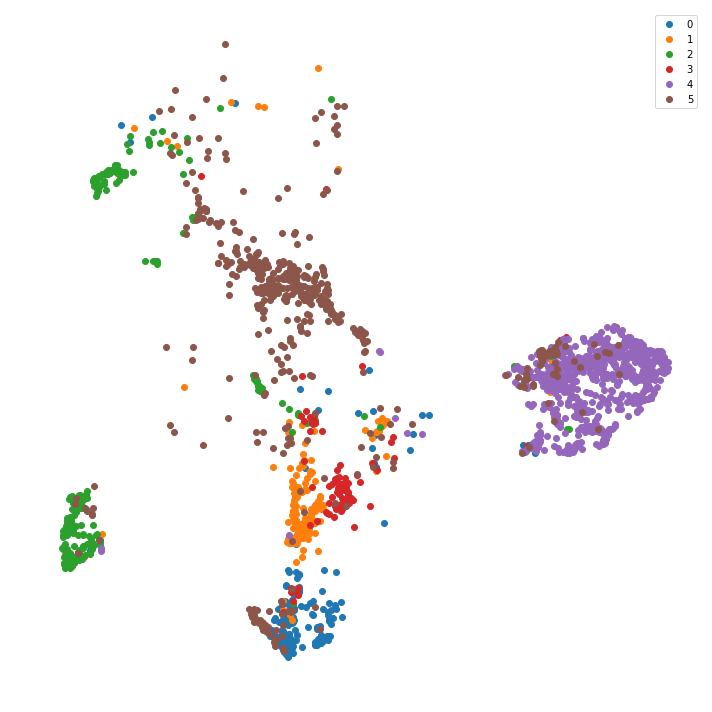

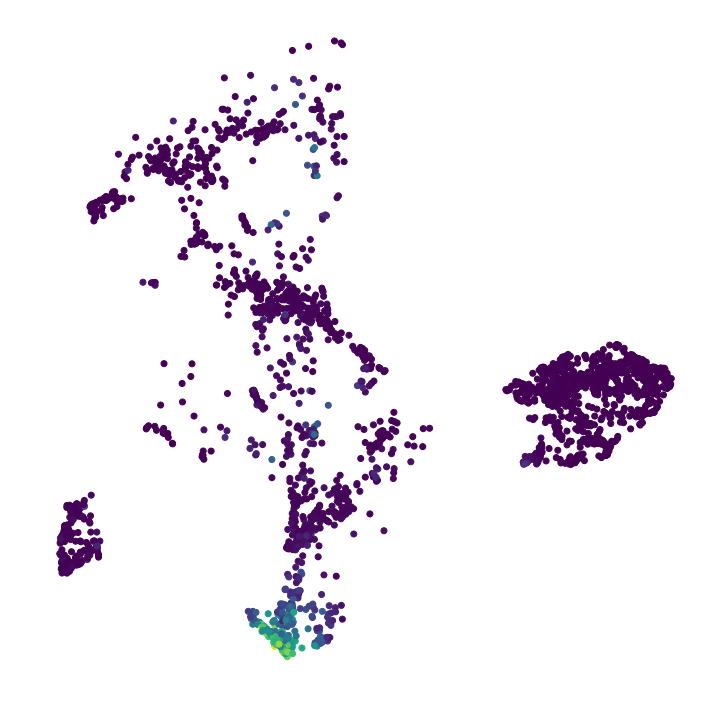

In [50]:
idx_interest = idx_astro
#idx_interest = idx_oligo
#idx_interest = idx_interneurons
trainer.train_fish.show_t_sne(None, color_by='labels', latent=t_sne_seq, labels=gene_dataset_seq.labels.ravel())
trainer.train_fish.show_t_sne(None, color_by='scalar', save_name="", latent=t_sne_seq, batch_indices=None,
                        labels=expected_frequencies_seq[:, idx_interest])

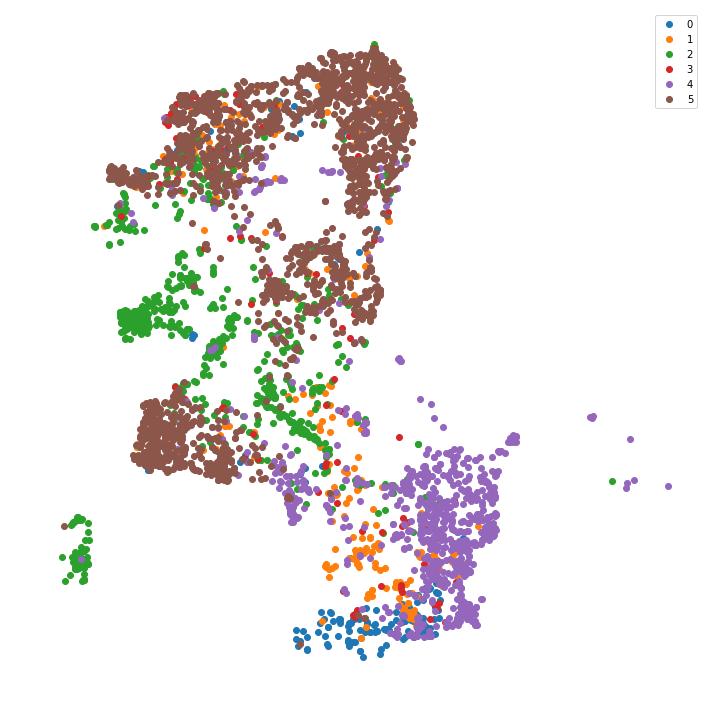

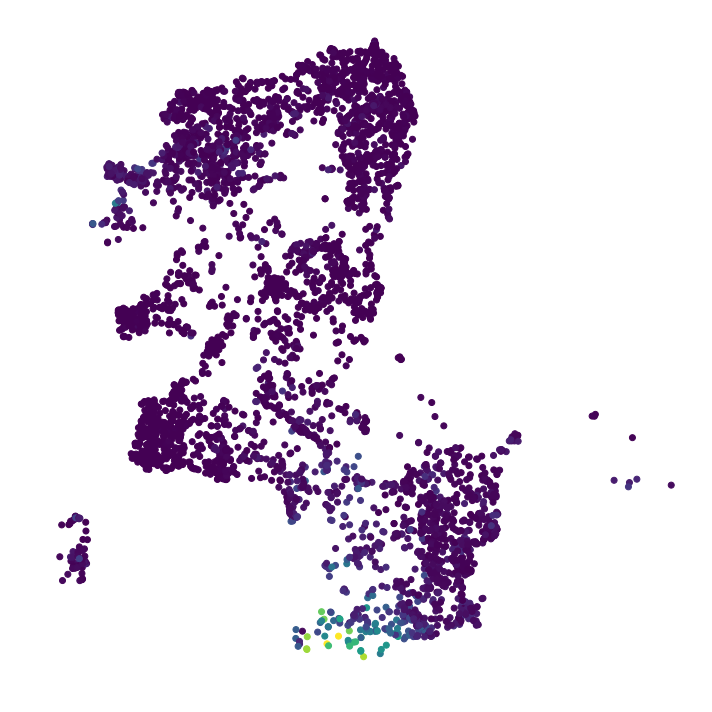

In [97]:
idx_interest = idx_astro
#idx_interest = idx_oligo
#idx_interest = idx_interneurons
trainer.train_fish.show_t_sne(None, color_by='labels', latent=t_sne_fish, labels=gene_dataset_fish.labels.ravel())
trainer.train_fish.show_t_sne(None, color_by='scalar', save_name="", latent=t_sne_fish, batch_indices=None,
                        labels=expected_frequencies_fish[:, idx_interest])

# 6. Going further: Imputing unobserved genes for the smFISH experiment

First, we impute marker genes for different cell types, to ensure the consistency of our model

## Spatial imputation

Now that we can impute values for smFISH cells, we can estimate a spatial map for the gene expression of genes sequenced with scRNA-seq

In [77]:
idx_interest = idx_astro
#idx_interest = idx_oligo
#idx_interest = idx_interneurons

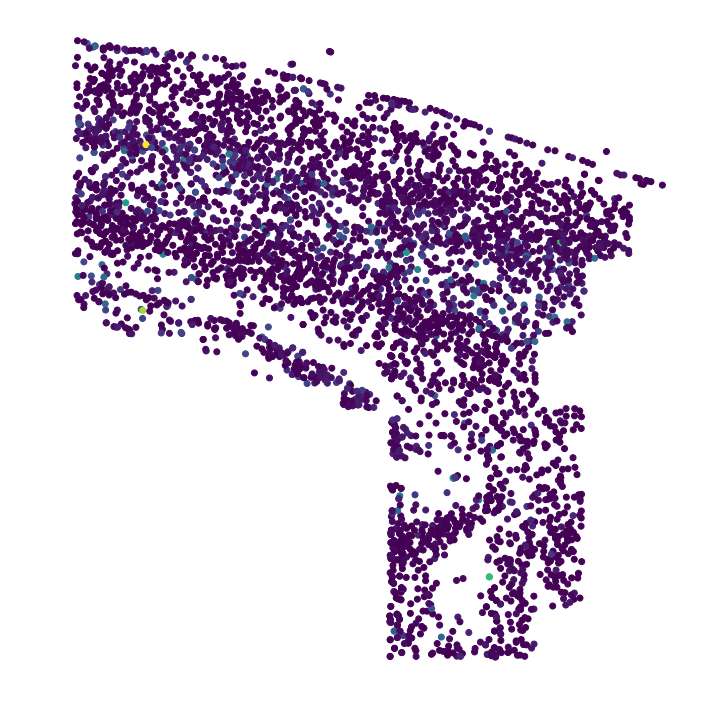

In [78]:
trainer.train_fish.show_spatial_expression(gene_dataset_fish.x_coord.ravel(), gene_dataset_fish.y_coord.ravel(),
                        expected_frequencies_fish[:, idx_interest],
                        title="")

## Finding spatially differentialy expressed genes

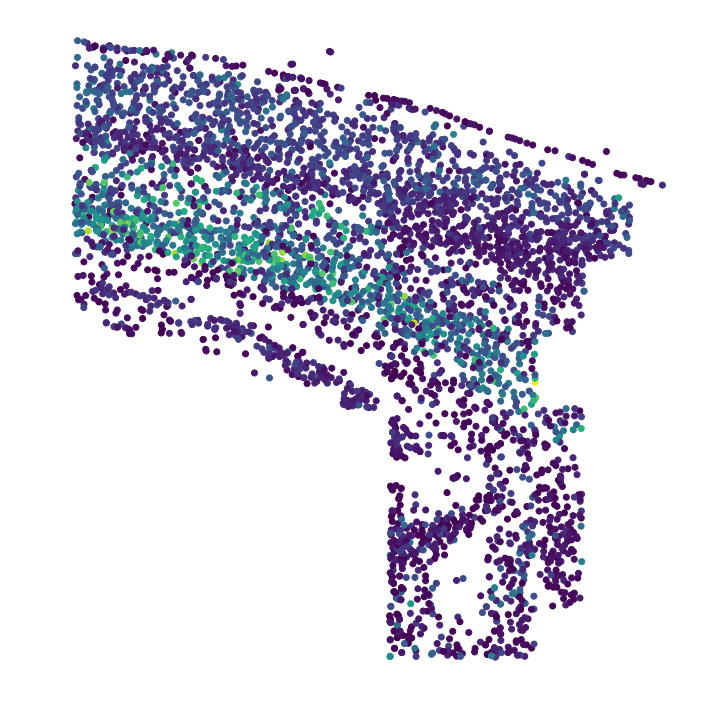

In [79]:
trainer.train_fish.show_spatial_expression(gene_dataset_fish.x_coord.ravel(), gene_dataset_fish.y_coord.ravel(),
                        expected_frequencies_fish[:, 45],
                        title="")

In [ ]:
def allow_notebook_for_test():
    print("Testing the scRNA and smFISH notebook")